## PINN_2D_oscillator.ipynb

## 2D time-dependent Burgers equation
The example problem we solve here is the 2D time-dependent Burgers equations as example for the 2D damped harmonic oscillator:
$$
\dfrac{d u}{dt} + u * \dfrac{d u}{d x} = \nu * \dfrac{d^2 u}{d^2 x} ,
$$
in the interval:
$$
-1 < x < 1~~~,~~~ 0 < t
$$
with the initial and boundary conditions:
$$
u(x,0) = \sin(\pi * x), ~~~ u(-1,t) = u(+1,t) = 0
$$
This problem is taken from the original PINN paper: https://maziarraissi.github.io/PINNs/

### Import all what you need:

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

### Generate boundary training points:

In [2]:
x1 = torch.stack([-torch.ones(40), torch.linspace(0,1,40)],-1)
u1 = torch.zeros_like(x1[:,0:1])
print(x1.shape, u1.shape)
#x1

torch.Size([40, 2]) torch.Size([40, 1])


In [3]:
#u1

In [4]:
x2 = torch.stack([torch.ones(40), torch.linspace(0,1,40)],-1)
u2 = torch.zeros_like(x2[:,0:1])
print(x2.shape, u2.shape)
#x2

torch.Size([40, 2]) torch.Size([40, 1])


In [5]:
#u2

In [6]:
x3 = torch.stack([torch.linspace(-1,1,40), torch.zeros(40)],-1)
u3 = -torch.sin(np.pi*x3[:,0:1])
print(x3.shape, u3.shape)
#x3

torch.Size([40, 2]) torch.Size([40, 1])


In [7]:
#u3

In [8]:
### Generate physic loss sample points:
# get physics loss sample points over full domain
xs = [torch.linspace(-1,1,40), torch.linspace(0,1,40)]
xs

[tensor([-1.0000, -0.9487, -0.8974, -0.8462, -0.7949, -0.7436, -0.6923, -0.6410,
         -0.5897, -0.5385, -0.4872, -0.4359, -0.3846, -0.3333, -0.2821, -0.2308,
         -0.1795, -0.1282, -0.0769, -0.0256,  0.0256,  0.0769,  0.1282,  0.1795,
          0.2308,  0.2821,  0.3333,  0.3846,  0.4359,  0.4872,  0.5385,  0.5897,
          0.6410,  0.6923,  0.7436,  0.7949,  0.8462,  0.8974,  0.9487,  1.0000]),
 tensor([0.0000, 0.0256, 0.0513, 0.0769, 0.1026, 0.1282, 0.1538, 0.1795, 0.2051,
         0.2308, 0.2564, 0.2821, 0.3077, 0.3333, 0.3590, 0.3846, 0.4103, 0.4359,
         0.4615, 0.4872, 0.5128, 0.5385, 0.5641, 0.5897, 0.6154, 0.6410, 0.6667,
         0.6923, 0.7179, 0.7436, 0.7692, 0.7949, 0.8205, 0.8462, 0.8718, 0.8974,
         0.9231, 0.9487, 0.9744, 1.0000])]

In [9]:
x_physics = torch.stack(torch.meshgrid(*xs, indexing='ij'), -1).view(-1, 2).requires_grad_(True)
print(x_physics.shape)
x_physics

torch.Size([1600, 2])


tensor([[-1.0000,  0.0000],
        [-1.0000,  0.0256],
        [-1.0000,  0.0513],
        ...,
        [ 1.0000,  0.9487],
        [ 1.0000,  0.9744],
        [ 1.0000,  1.0000]], requires_grad=True)

In [10]:
### Generate testing points:
# get testing locations
xs = [torch.linspace(-1,1,100), torch.linspace(0,1,100)]
xs


[tensor([-1.0000, -0.9798, -0.9596, -0.9394, -0.9192, -0.8990, -0.8788, -0.8586,
         -0.8384, -0.8182, -0.7980, -0.7778, -0.7576, -0.7374, -0.7172, -0.6970,
         -0.6768, -0.6566, -0.6364, -0.6162, -0.5960, -0.5758, -0.5556, -0.5354,
         -0.5152, -0.4949, -0.4747, -0.4545, -0.4343, -0.4141, -0.3939, -0.3737,
         -0.3535, -0.3333, -0.3131, -0.2929, -0.2727, -0.2525, -0.2323, -0.2121,
         -0.1919, -0.1717, -0.1515, -0.1313, -0.1111, -0.0909, -0.0707, -0.0505,
         -0.0303, -0.0101,  0.0101,  0.0303,  0.0505,  0.0707,  0.0909,  0.1111,
          0.1313,  0.1515,  0.1717,  0.1919,  0.2121,  0.2323,  0.2525,  0.2727,
          0.2929,  0.3131,  0.3333,  0.3535,  0.3737,  0.3939,  0.4141,  0.4343,
          0.4545,  0.4747,  0.4949,  0.5152,  0.5354,  0.5556,  0.5758,  0.5960,
          0.6162,  0.6364,  0.6566,  0.6768,  0.6970,  0.7172,  0.7374,  0.7576,
          0.7778,  0.7980,  0.8182,  0.8384,  0.8586,  0.8788,  0.8990,  0.9192,
          0.9394,  0.9596,  

In [11]:
x_test = torch.stack(torch.meshgrid(*xs, indexing='ij'), -1).view(-1, 2)
print(x_test.shape)
x_test

torch.Size([10000, 2])


tensor([[-1.0000,  0.0000],
        [-1.0000,  0.0101],
        [-1.0000,  0.0202],
        ...,
        [ 1.0000,  0.9798],
        [ 1.0000,  0.9899],
        [ 1.0000,  1.0000]])

### Definition of the Fully Connected Neural Network Class:

In [12]:
# define NN
class FCN(nn.Module):
    "Defines a fully-connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [13]:
nu=0.01/np.pi
torch.manual_seed(123)

In [14]:
model = FCN(2,1,64,4)
model

FCN(
  (fcs): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Tanh()
  )
  (fch): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
    )
  )
  (fce): Linear(in_features=64, out_features=1, bias=True)
)

In [15]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [16]:
model.parameters()

<generator object Module.parameters at 0x7fb361b74ac0>

### One Epoch:

In [17]:
optimizer.zero_grad()

In [18]:
# compute the "data loss"
y1, y2, y3 = model(x1), model(x2), model(x3)
y1

tensor([[0.1019],
        [0.1020],
        [0.1020],
        [0.1020],
        [0.1021],
        [0.1021],
        [0.1022],
        [0.1023],
        [0.1024],
        [0.1025],
        [0.1026],
        [0.1027],
        [0.1028],
        [0.1029],
        [0.1030],
        [0.1032],
        [0.1033],
        [0.1035],
        [0.1036],
        [0.1038],
        [0.1040],
        [0.1042],
        [0.1043],
        [0.1045],
        [0.1047],
        [0.1049],
        [0.1052],
        [0.1054],
        [0.1056],
        [0.1058],
        [0.1061],
        [0.1063],
        [0.1065],
        [0.1068],
        [0.1070],
        [0.1073],
        [0.1075],
        [0.1078],
        [0.1081],
        [0.1083]], grad_fn=<AddmmBackward0>)

In [19]:
loss1 = torch.mean((y1-u1)**2) + torch.mean((y2-u2)**2) + torch.mean((y3-u3)**2)
loss1

tensor(0.4950, grad_fn=<AddBackward0>)

In [20]:
# compute the "physics loss"
yp = model(x_physics)
yp.size()

torch.Size([1600, 1])

In [21]:
dx  = torch.autograd.grad(yp, x_physics, torch.ones_like(yp), create_graph=True)[0]# computes dy/dx
dx.size()

torch.Size([1600, 2])

In [22]:
dx1, dx2 = dx[:,0:1], dx[:,1:2]
dx1.size()

torch.Size([1600, 1])

In [23]:
dx2 == dx2[:,0]

tensor([[ True, False, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        ...,
        [False, False, False,  ...,  True, False, False],
        [False, False, False,  ..., False,  True, False],
        [False, False, False,  ..., False, False,  True]])

In [24]:
dx1dx = torch.autograd.grad(dx1, x_physics, torch.ones_like(dx1), create_graph=True)[0]# computes d^2y/dx^2
dx1dx

tensor([[ 0.0017,  0.0044],
        [ 0.0015,  0.0048],
        [ 0.0014,  0.0052],
        ...,
        [ 0.0160, -0.0089],
        [ 0.0159, -0.0090],
        [ 0.0159, -0.0091]], grad_fn=<MmBackward0>)

In [25]:
dx1dx1 = dx1dx[:,0:1]
dx1dx1

tensor([[0.0017],
        [0.0015],
        [0.0014],
        ...,
        [0.0160],
        [0.0159],
        [0.0159]], grad_fn=<SliceBackward0>)

$$
\dfrac{d u}{dt} + u * \dfrac{d u}{d x} = \nu * \dfrac{d^2 u}{d^2 x} ,
$$

In [26]:
# computes the residual of the Burgers equation
physics = (dx2[:,0] + yp[:,0] * dx1[:,0]) - (nu * dx1dx1[:,0])
physics.size()

torch.Size([1600])

In [27]:
loss2 = (0.1)*torch.mean(physics**2)
loss2

tensor(9.7288e-06, grad_fn=<MulBackward0>)

In [28]:
# backpropagate joint loss
loss = loss1 + loss2# add two loss terms together
loss

tensor(0.4950, grad_fn=<AddBackward0>)

In [29]:
loss.backward()
optimizer.step()

In [30]:
y = model(x_test)
y

tensor([[0.1011],
        [0.1011],
        [0.1011],
        ...,
        [0.0576],
        [0.0578],
        [0.0579]], grad_fn=<AddmmBackward0>)

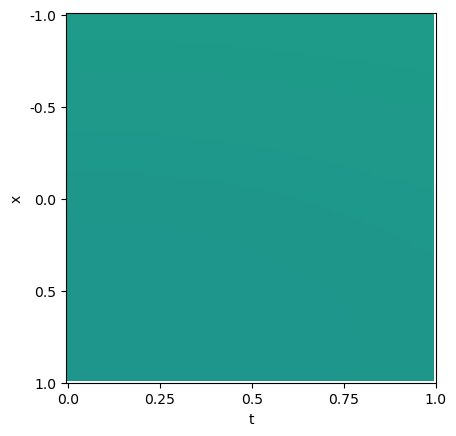

In [31]:
# plot the result as training progresses
plt.figure()
plt.imshow(y.reshape(100,100).detach(), vmin=-1, vmax=1)
plt.xticks(np.linspace(0,100,5).astype(int), np.linspace(0,1,5))
plt.yticks(np.linspace(0,100,5).astype(int), np.linspace(-1,1,5))
plt.xlabel("t"); plt.ylabel("x")
#plt.title("Training step: %i"%(i+1))
plt.show()
	

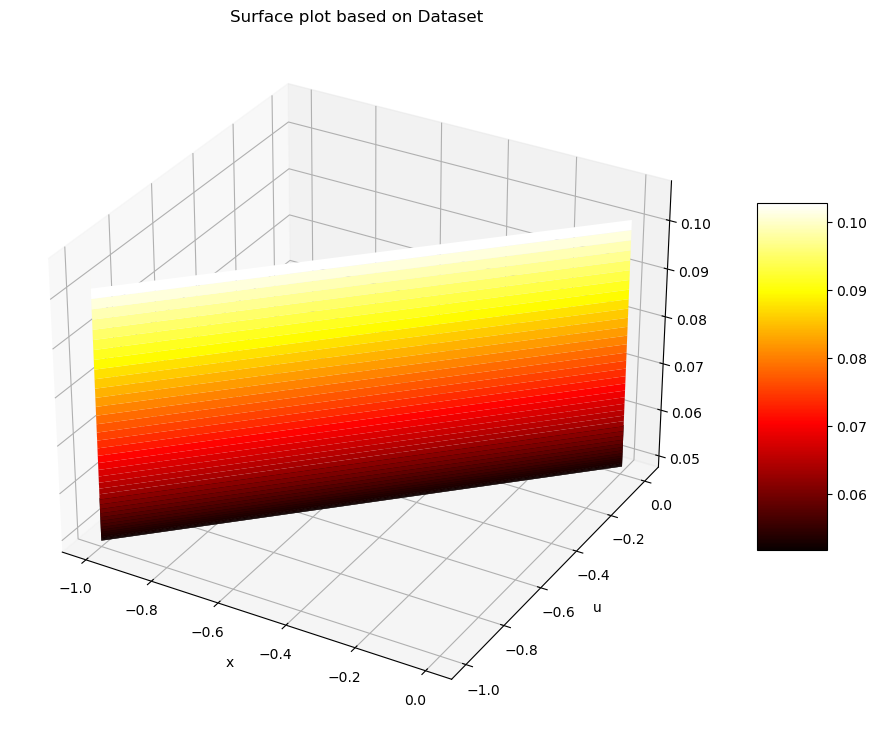

In [32]:
# Creating 3D figure:
fig = plt.figure(figsize =(14, 9)) 
ax = plt.axes(projection ='3d') 

# Creating color map 
my_cmap = plt.get_cmap('hot') 

# Creating plot 
surf = ax.plot_surface(x_test[0].detach().numpy(), x_test[1].detach().numpy(), y.detach().numpy(), cmap = my_cmap, edgecolor ='none') 

fig.colorbar(surf, ax = ax, shrink = 0.5, aspect = 5) 

ax.set_title('Surface plot based on Dataset') 
plt.xlabel("x")
plt.ylabel("t")
plt.ylabel("u")

# show plot 
plt.show() 




In [33]:
#for i in range(10000):
#    optimizer.zero_grad()
#    
#    # compute the "data loss"
#    y1, y2, y3 = model(x1), model(x2), model(x3)
#    loss1 = torch.mean((y1-u1)**2) + torch.mean((y2-u2)**2) + torch.mean((y3-u3)**2)
#    
#    # compute the "physics loss"
#    yp = model(x_physics)
#    dx  = torch.autograd.grad(yp, x_physics, torch.ones_like(yp), create_graph=True)[0]# computes dy/dx
#    dx1, dx2 = dx[:,0:1], dx[:,1:2]
#    dx1dx = torch.autograd.grad(dx1, x_physics, torch.ones_like(dx1), create_graph=True)[0]# computes d^2y/dx^2
#    dx1dx1 = dx1dx[:,0:1]
#    physics = (dx2[:,0] + yp[:,0] * dx1[:,0]) - (nu * dx1dx1[:,0])# computes the residual of the Burgers equation
#    loss2 = (0.1)*torch.mean(physics**2)
#    
#    # backpropagate joint loss
#    loss = loss1 + loss2# add two loss terms together
#    loss.backward()
#    optimizer.step()
#    
#    
#    # plot the result as training progresses
#    if (i+1) % 1000 == 0: 
#        y = model(x_test)
#        plt.figure()
#        plt.imshow(y.reshape(100,100).detach(), vmin=-1, vmax=1)
#        plt.xticks(np.linspace(0,100,5).astype(int), np.linspace(0,1,5))
#        plt.yticks(np.linspace(0,100,5).astype(int), np.linspace(-1,1,5))
#        plt.xlabel("t"); plt.ylabel("x")
#        plt.title("Training step: %i"%(i+1))
#        plt.show()
#